In [89]:
import matplotlib.pyplot as plt
import cv2 
import pytesseract
from PIL import Image
from reportlab.lib.pagesizes import A4, letter
# Adding custom options

custom_config = r'--oem 2 --psm 12 -l fra'



In [90]:
A4_int = (int(round(A4[0])), int(round(A4[1])))

In [91]:
img = cv2.imread('img/test.png',cv2.IMREAD_UNCHANGED)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (A4_int[0],A4_int[1]) ,interpolation=cv2.INTER_CUBIC)

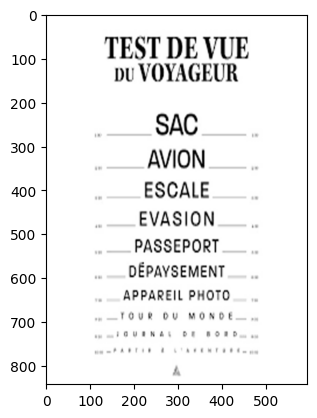

In [92]:
plt.imshow(img)

In [93]:
# cv2.imshow('image',img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [94]:
test = pytesseract.image_to_string(Image.fromarray(img), config=custom_config)
test

'TEST DE VUE\n\nDu VOYAGEUR\n\nSAC\n\nAVION\n\nESCALE\n\nEVASION\n\nPASSEPORT\n\nDÉPAYSEMENT\n\nAPPAREIL PHOTO\n\nTOUR DU MONDE\n\necurand\n\x0c'

In [95]:
# Perform OCR on the RGB image using pytesseract
text = pytesseract.image_to_data(Image.fromarray(img),output_type='dict',config=custom_config)

In [96]:
boxes = len(text['level'])
for i in range(boxes ):
    (x, y, w, h) = (text['left'][i], text['top'][i], text['width'][i], text['height'][i])
    #Draw box        
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

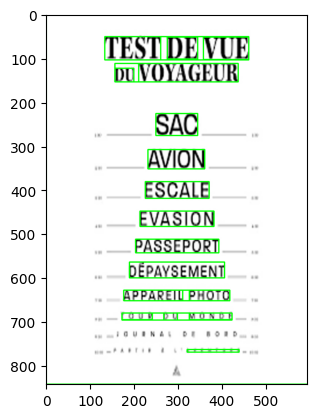

In [97]:
plt.imshow(img)

In [98]:
for i in range(boxes ):
    (x, y, w, h,chara) = (text['left'][i], text['top'][i], text['width'][i], text['height'][i],text["text"][i])
    print(x, y, w, h,chara)

0 0 595 842 
133 51 327 53 
133 51 327 53 
133 51 327 53 
133 51 127 53 TEST
275 52 69 50 DE
357 52 103 51 VUE
156 112 280 42 
156 112 280 42 
156 112 280 42 
156 123 43 31 Du
210 112 226 42 VOYAGEUR
249 226 95 50 
249 226 95 50 
249 226 95 50 
249 226 95 50 SAC
231 308 129 44 
231 308 129 44 
231 308 129 44 
231 308 129 44 AVION
225 381 145 38 
225 381 145 38 
225 381 145 38 
225 381 145 38 ESCALE
213 448 168 35 
213 448 168 35 
213 448 168 35 
213 448 168 35 EVASION
203 512 189 31 
203 512 189 31 
203 512 189 31 
203 512 189 31 PASSEPORT
189 564 216 36 
189 564 216 36 
189 564 216 36 
189 564 216 36 DÉPAYSEMENT
176 628 241 24 
176 628 241 24 
176 628 241 24 
176 628 134 24 APPAREIL
325 628 92 24 PHOTO
172 680 250 16 
172 680 250 16 
172 680 250 16 
172 680 69 15 TOUR
267 680 31 16 DU
325 680 97 15 MONDE
320 763 118 6 
320 763 118 6 
320 763 118 6 
320 763 118 6 ecurand


In [99]:
from reportlab.pdfgen import canvas

def hello(c,left,top,text):
    c.drawString(left,top,text)
c = canvas.Canvas("hello.pdf")
for i in range(boxes ):
    (x, y, w, h,chara) = (text['left'][i],A4[1] - text['top'][i], text['width'][i], text['height'][i],text["text"][i])
    hello(c,x,y,chara)
c.showPage()
c.save()